<a href="https://colab.research.google.com/github/anuvrat-umich/siads_milestone1/blob/main/data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [ ]:
### Author: Alex Chan
### Date: 13-Feb-2024
### Purpose: In depth analysis and visualizaiton at a sub-national (state) level.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


# Imports and Helper Functions


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
import ipywidgets as widgets
from IPython.display import display
import re
import folium
import seaborn as sn
import numpy as np
import matplotlib.ticker as ticker
from scipy import stats
import seaborn as sns
from shapely.geometry import Point

In [ ]:
# Clean income data
def clean_income_data(data):
    income_data = pd.read_csv(data, header=None)

    new_header = income_data.iloc[1]  # store second row
    income_data = income_data[2:]  # remove first 2 rows
    income_data.columns = new_header  # make header previous second row

    income_data["Geographic Area Name"] = income_data[
        "Geographic Area Name"
    ].str.extract(
        "(\d{5})"
    )  # Get just the zip code

    # Filter specific columns
    income_data = income_data[
        ["Geographic Area Name", "Estimate!!Households!!Mean income (dollars)"]
    ]

    income_data.columns = [["Zip Code", "Households Mean Income"]]

    return income_data

In [ ]:
# Clean health outcomes data
def clean_health_data(data):
    health_data = pd.read_csv(data)
    health_data["LocationName"] = health_data["LocationName"].astype(str).str.zfill(5)

    return health_data

# Load Data


In [ ]:
# 2022 Income Data
income_data_2022 = clean_income_data(
    "/content/drive/MyDrive/Milestone1/income_data_2022.csv"
)

<ipython-input-3-dc5140cc50a0>:3: DtypeWarning: Columns (2,3,34,35,66,67,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  income_data = pd.read_csv(data, header=None)
<ipython-input-3-dc5140cc50a0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_data['Geographic Area Name'] = income_data['Geographic Area Name'].str.extract('(\d{5})') # Get just the zip code


In [ ]:
# Health Outcomes
health_outcomes = clean_health_data(
    "/content/drive/MyDrive/Milestone1/health_outcomes.csv"
)

<ipython-input-4-6f4f8c5429aa>:3: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  health_data = pd.read_csv(data)


In [ ]:
# Zip Codes
zip_codes = pd.read_excel("/content/drive/MyDrive/Milestone1/zip_codes.xlsx")

# View Data


In [ ]:
income_data_2022.head(1)

,Zip Code,Households Mean Income
2,00601,23091


In [ ]:
health_outcomes.head(1)

,Year,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,Data_Value_Footnote_Symbol,Data_Value_Footnote,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,Geolocation,LocationID,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text
0,2021,01001,BRFSS,Prevention,Current lack of health insurance among adults ...,%,Crude prevalence,4.1,NaN,NaN,3.4,5.0,16769,POINT (-72.62581515 42.06255509),1001,PREVENT,ACCESS2,CrdPrv,Health Insurance


In [ ]:
zip_codes.head(1)

,Zip Code,Official USPS city name,Official USPS State Code,Official State Name,ZCTA,ZCTA parent,Population,Density,Primary Official County Code,Primary Official County Name,County Weights,Official County Name,Official County Code,Imprecise,Military,Timezone,Geo Point
0,90005,Los Angeles,CA,California,True,NaN,39732.0,14151.8,6037,Los Angeles,"{""06037"": ""100""}",Los Angeles,6037,False,False,America/Los_Angeles,"34.05912, -118.30654"


# Box Plots of Income


In [ ]:
states = zip_codes["Official State Name"].unique()
states = states.tolist()
remove = [
    "Guam",
    "Puerto Rico",
    "District of Columbia",
    "Northern Mariana Islands",
    "Virgin Islands",
    "American Samoa",
]
states = sorted(list(filter(lambda item: item not in remove, states)))

In [ ]:
state_zips = zip_codes[["Zip Code", "Official State Name"]]
state_zips["Zip Code"] = state_zips["Zip Code"].astype(str)
state_zips = state_zips.sort_values(by=["Zip Code"])

<ipython-input-12-d9fff1f012d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_zips['Zip Code'] = state_zips['Zip Code'].astype(str)


In [ ]:
income_data_2022.columns = income_data_2022.columns.get_level_values(0)
income_data_2022["Zip Code"] = income_data_2022["Zip Code"].astype(str).str.zfill(5)
income_data_2022 = income_data_2022.sort_values(by=["Zip Code"])

In [ ]:
data_merged = state_zips.merge(income_data_2022, how="inner", on="Zip Code")


for column in data_merged.columns:
    # Skip the 'Official State Name' column
    if column != "Official State Name":
        # Convert the column to numeric first to handle non-numeric values
        data_merged[column] = pd.to_numeric(data_merged[column], errors="coerce")
        # Drop rows with NaN values that resulted from coercion (if desired)
        data_merged.dropna(subset=[column], inplace=True)
        # Convert the column to integers, assuming NaN values are handled or non-existent
        data_merged[column] = data_merged[column].astype(int)

# Drop rows with NaN values (rows that contained non-numeric data)
data_merged.dropna(inplace=True)
data_merged = data_merged.sort_values(by=["Official State Name"])

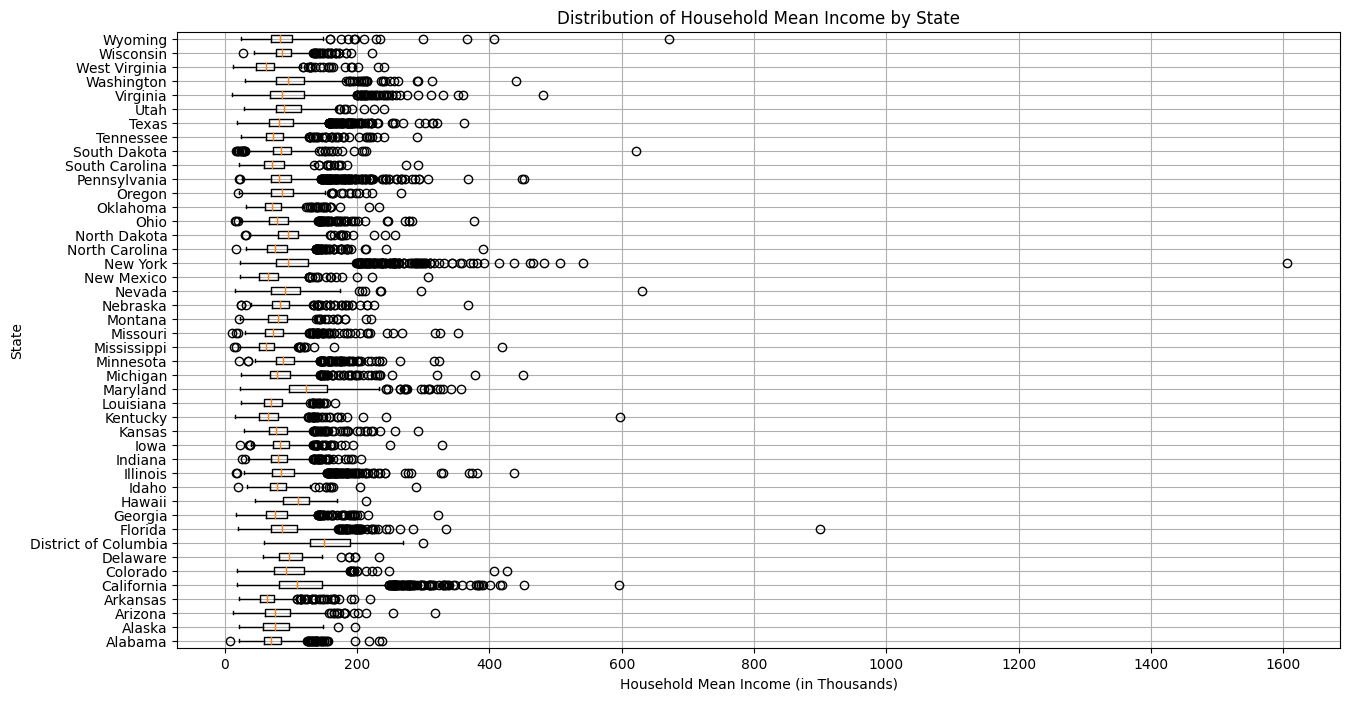

In [ ]:
# Group the data by 'Official State Name'
grouped_data = data_merged.groupby("Official State Name")

# Create an empty list to store boxplot data
boxplot_data = []

# Extract income data for each state and store it in the list
for state, group in grouped_data:
    boxplot_data.append((group["Households Mean Income"] / 1000).values)

# Create a boxplot
plt.figure(figsize=(15, 8))
plt.boxplot(boxplot_data, labels=grouped_data.groups.keys(), vert=False)
plt.title("Distribution of Household Mean Income by State")
plt.xlabel("Household Mean Income (in Thousands)")
plt.ylabel("State")
plt.grid(True)

plt.show()

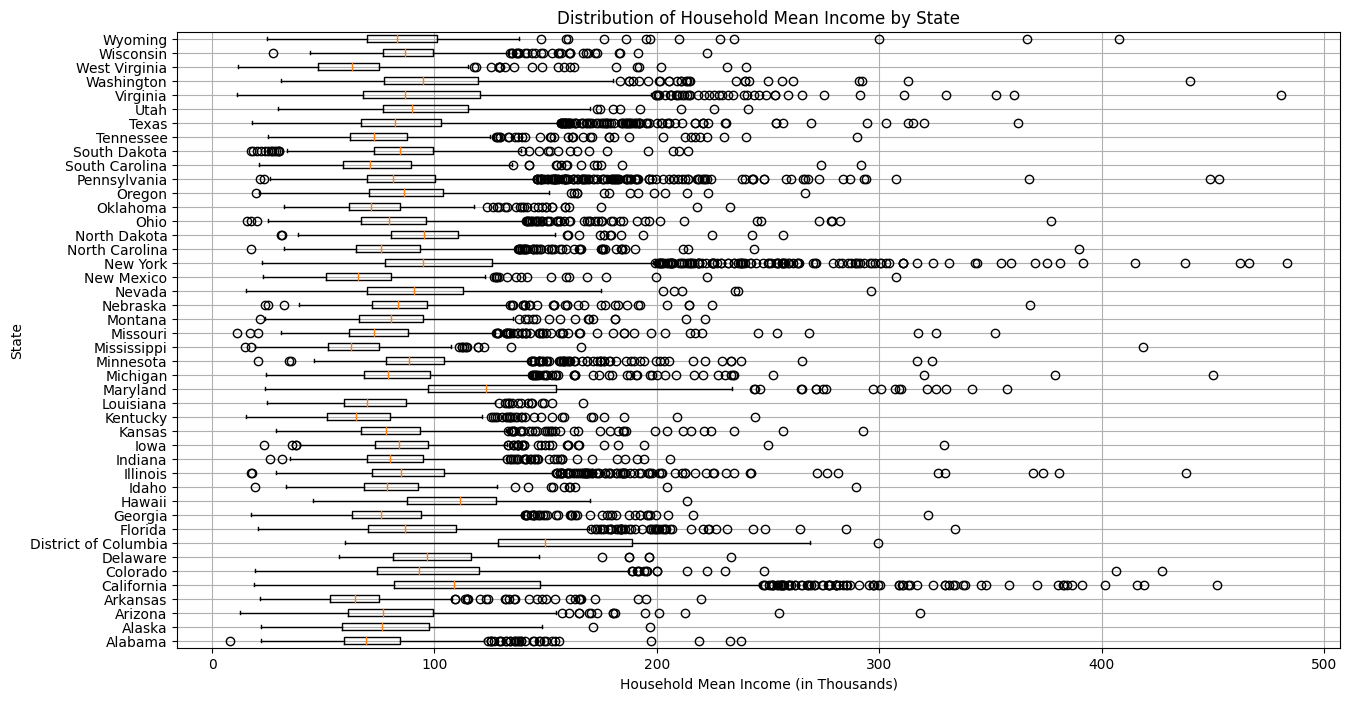

In [ ]:
condensed = data_merged[data_merged["Households Mean Income"] < 500000]

# Group the data by 'Official State Name'
grouped_data = condensed.groupby("Official State Name")

# Create an empty list to store boxplot data
boxplot_data = []

# Extract income data for each state and store it in the list
for state, group in grouped_data:
    boxplot_data.append((group["Households Mean Income"] / 1000).values)

# Create a boxplot
plt.figure(figsize=(15, 8))
plt.boxplot(boxplot_data, labels=grouped_data.groups.keys(), vert=False)
plt.title("Distribution of Household Mean Income by State")
plt.xlabel("Household Mean Income (in Thousands)")
plt.ylabel("State")
plt.grid(True)

plt.show()

# Histograms of Incomes


In [ ]:
# Define bin edges
bin_edges = np.arange(0, 1000000 + 25000, 25000)  # +30000 to include the upper edge


def plot_histogram_for_state_with_bins(state_name):
    # Filter the DataFrame for the selected state
    filtered_data = data_merged[data_merged["Official State Name"] == state_name]

    # Plotting the histogram with predefined bins
    plt.figure(figsize=(15, 5))
    plt.hist(
        filtered_data["Households Mean Income"],
        bins=bin_edges,
        color="skyblue",
        edgecolor="black",
    )
    plt.title(f"Households Mean Income Distribution in {state_name}")
    plt.xlabel("Households Mean Income")
    plt.ylabel("Number of Zip Codes")
    plt.grid(axis="y", alpha=0.75)

    # Rotate x-axis ticks for better readability
    plt.xticks(bin_edges, rotation=45)

    # Adding a x-axis limit to make the plot neater
    plt.xlim(0, 750000)

    # Set x-axis tick formatting to plain style (no scientific notation)
    plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

    plt.show()

5


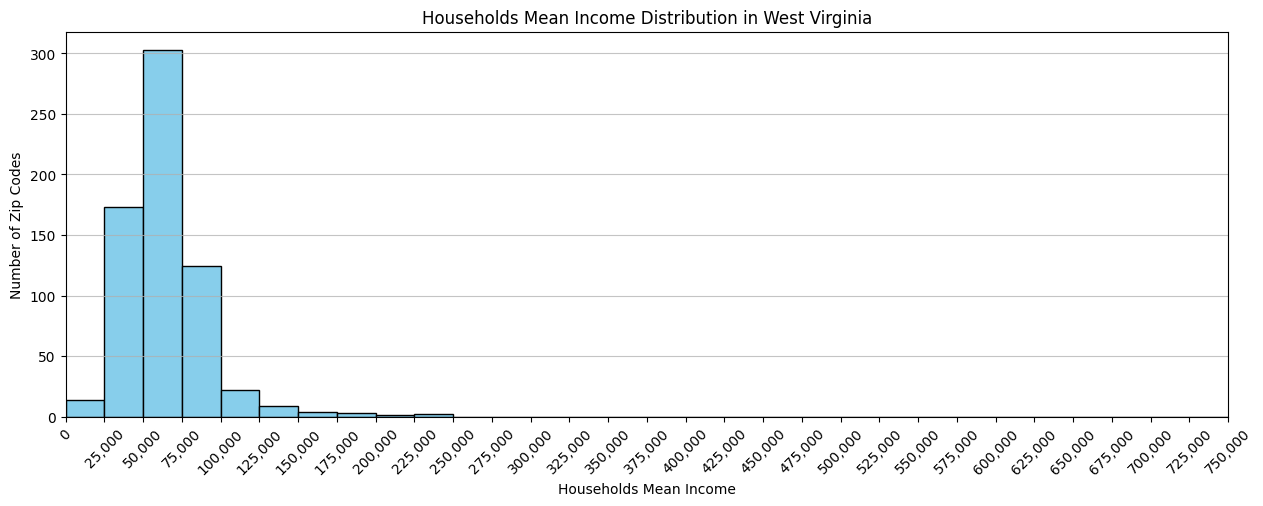

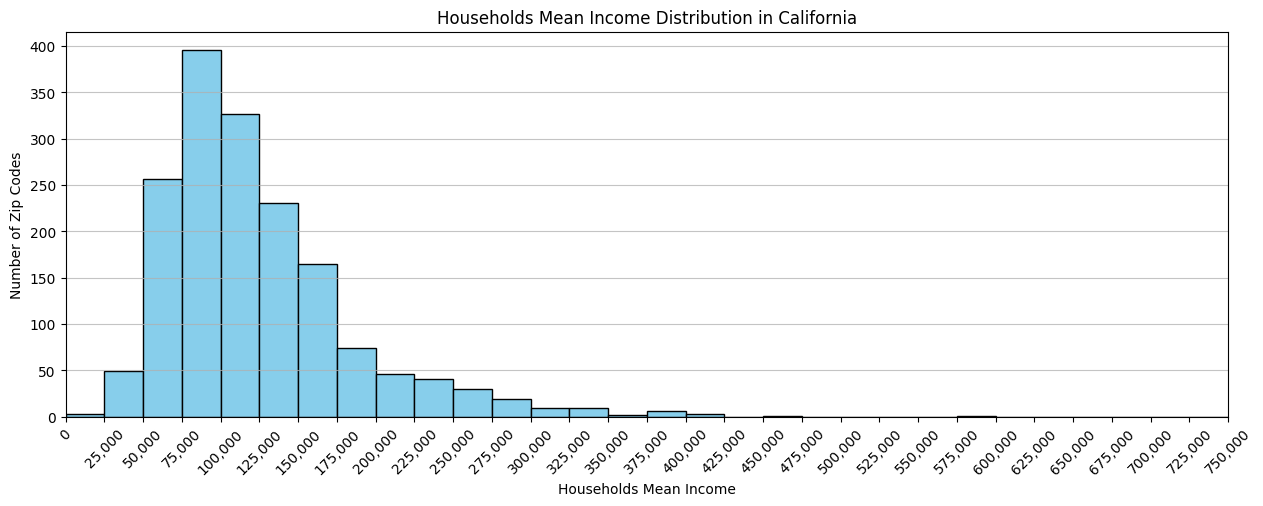

In [ ]:
states_to_show = ["West Virginia", "California"]
for s in states_to_show:
    plot_histogram_for_state_with_bins(s)

# Scatterplots of Health Outcomes


In [ ]:
# Load Income Data
income_2021 = clean_income_data(
    "/content/drive/MyDrive/Milestone1/income_data_2021.csv"
)

# Fix Multi-Index
income_2021.columns = income_2021.columns.get_level_values(0)
income_2021["Households Mean Income"] = pd.to_numeric(
    income_2021["Households Mean Income"], errors="coerce"
)
income_2021.dropna(subset=["Households Mean Income"], inplace=True)

<ipython-input-3-dc5140cc50a0>:3: DtypeWarning: Columns (2,3,34,35,66,67,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  income_data = pd.read_csv(data, header=None)


In [ ]:
def scatter_health_outcome(outcome, income_data, states_zips):
    # Cleann health outcome data
    health_data = health_outcomes[health_outcomes["Category"] == "Health Outcomes"]
    health_data = health_data[health_data["Year"] == 2021]
    health_data = health_data[
        ["LocationName", "Measure", "Data_Value", "Short_Question_Text"]
    ]
    health_data.columns = [["Zip Code", "Measure", "Value", "Text"]]
    health_data.columns = health_data.columns.get_level_values(0)

    merged_data = health_data.merge(income_data, how="inner", on="Zip Code")

    outcome_data = merged_data[merged_data["Text"] == outcome]

    # Merge to get State Names
    outcome_data["Zip Code"] = outcome_data["Zip Code"].astype(int)
    state_zips["Zip Code"] = state_zips["Zip Code"].astype(int)

    outcome_data_merged = state_zips.merge(outcome_data, how="inner", on="Zip Code")

    # Get avaerages of households mean income and outcome value
    average_outcome = (
        outcome_data_merged.groupby("Official State Name")
        .agg({"Value": "mean", "Households Mean Income": "mean"})
        .reset_index()
    )
    average_outcome.rename(
        columns={
            "Value": "Average Value",
            "Households Mean Income": "Average Households Mean Income",
        },
        inplace=True,
    )
    average_outcome["Average Value"] = average_outcome["Average Value"].round(2)
    average_outcome["Average Households Mean Income"] = average_outcome[
        "Average Households Mean Income"
    ].round()

    # Make Scatterplot
    y = average_outcome["Average Value"]
    x = average_outcome["Average Households Mean Income"] / 1000
    state_names = average_outcome["Official State Name"]

    # Create a scatter plot
    plt.figure(figsize=(15, 10))
    plt.scatter(x, y, alpha=0.5, color="b")

    # Annotate dots with state names
    for i, state in enumerate(state_names):
        plt.annotate(state, (x[i], y[i]), fontsize=10, alpha=0.7)

    # Calculate the linear regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line = slope * x + intercept

    # Plot the trendline and include R-squared value
    r_squared = r_value**2
    r_squared_text = f"R-squared = {r_squared:.2f}"
    plt.plot(
        x,
        line,
        color="r",
        label=f"Trendline: y = {slope:.2f}x + {intercept:.2f}\n{r_squared_text}",
    )

    plt.title(
        "Scatter Plot of {} vs Average Households Mean Income by State".format(outcome)
    )
    plt.xlabel("Average Households Mean Income (in Thousands)")
    plt.ylabel("Average %  of Population")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

<ipython-input-20-f1930b4ae5b7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_data['Zip Code'] = outcome_data['Zip Code'].astype(int)


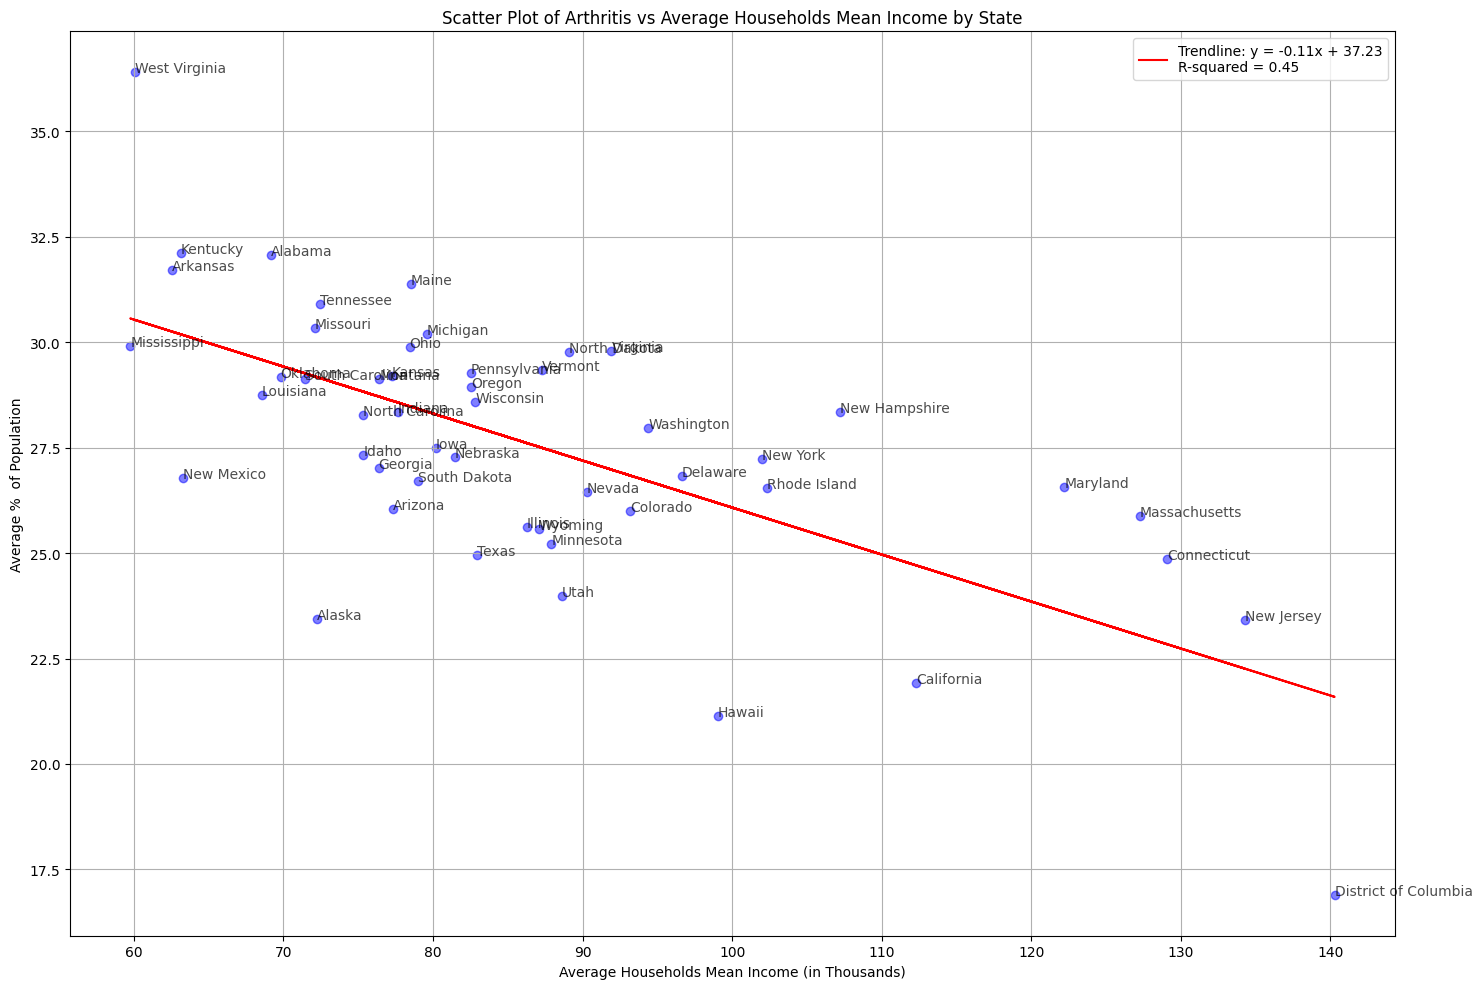

<ipython-input-20-f1930b4ae5b7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_data['Zip Code'] = outcome_data['Zip Code'].astype(int)


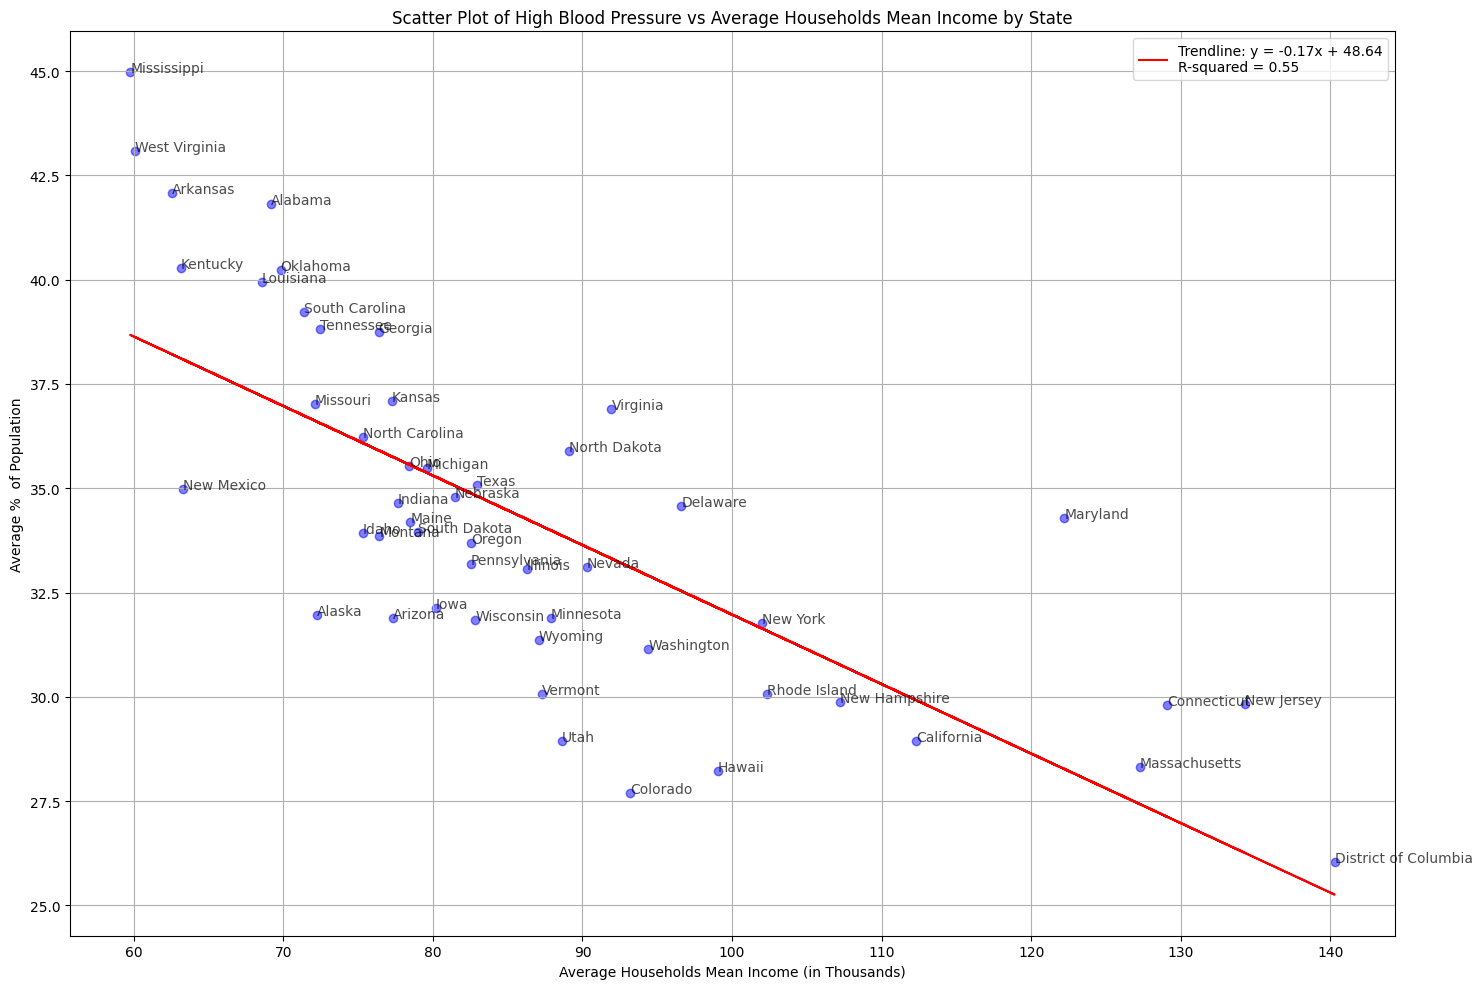

<ipython-input-20-f1930b4ae5b7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_data['Zip Code'] = outcome_data['Zip Code'].astype(int)


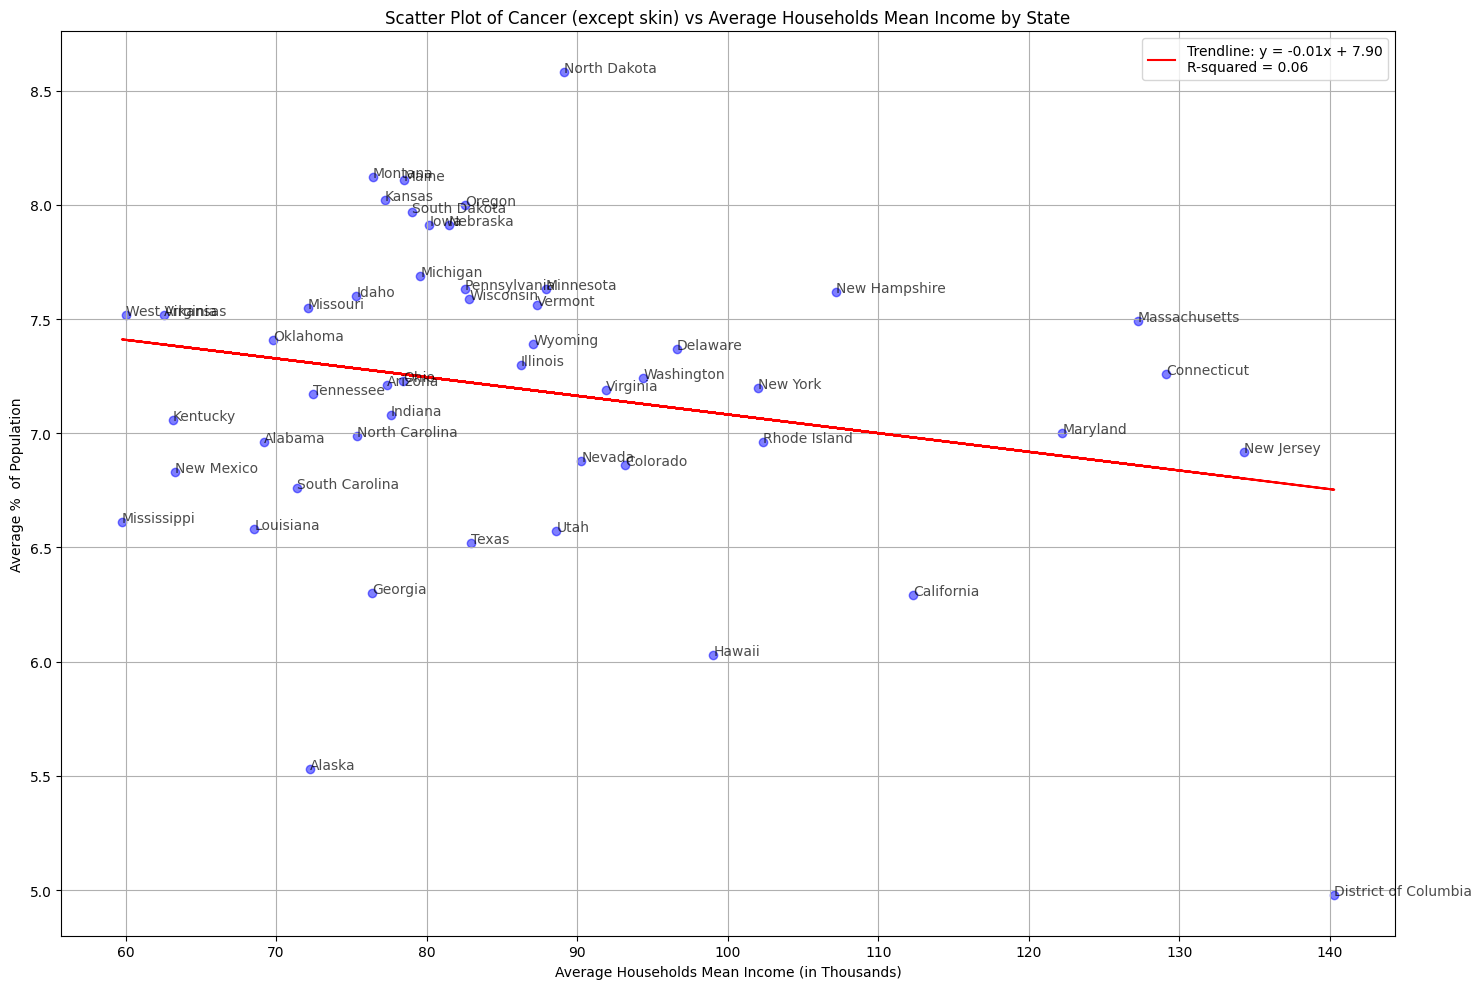

<ipython-input-20-f1930b4ae5b7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_data['Zip Code'] = outcome_data['Zip Code'].astype(int)


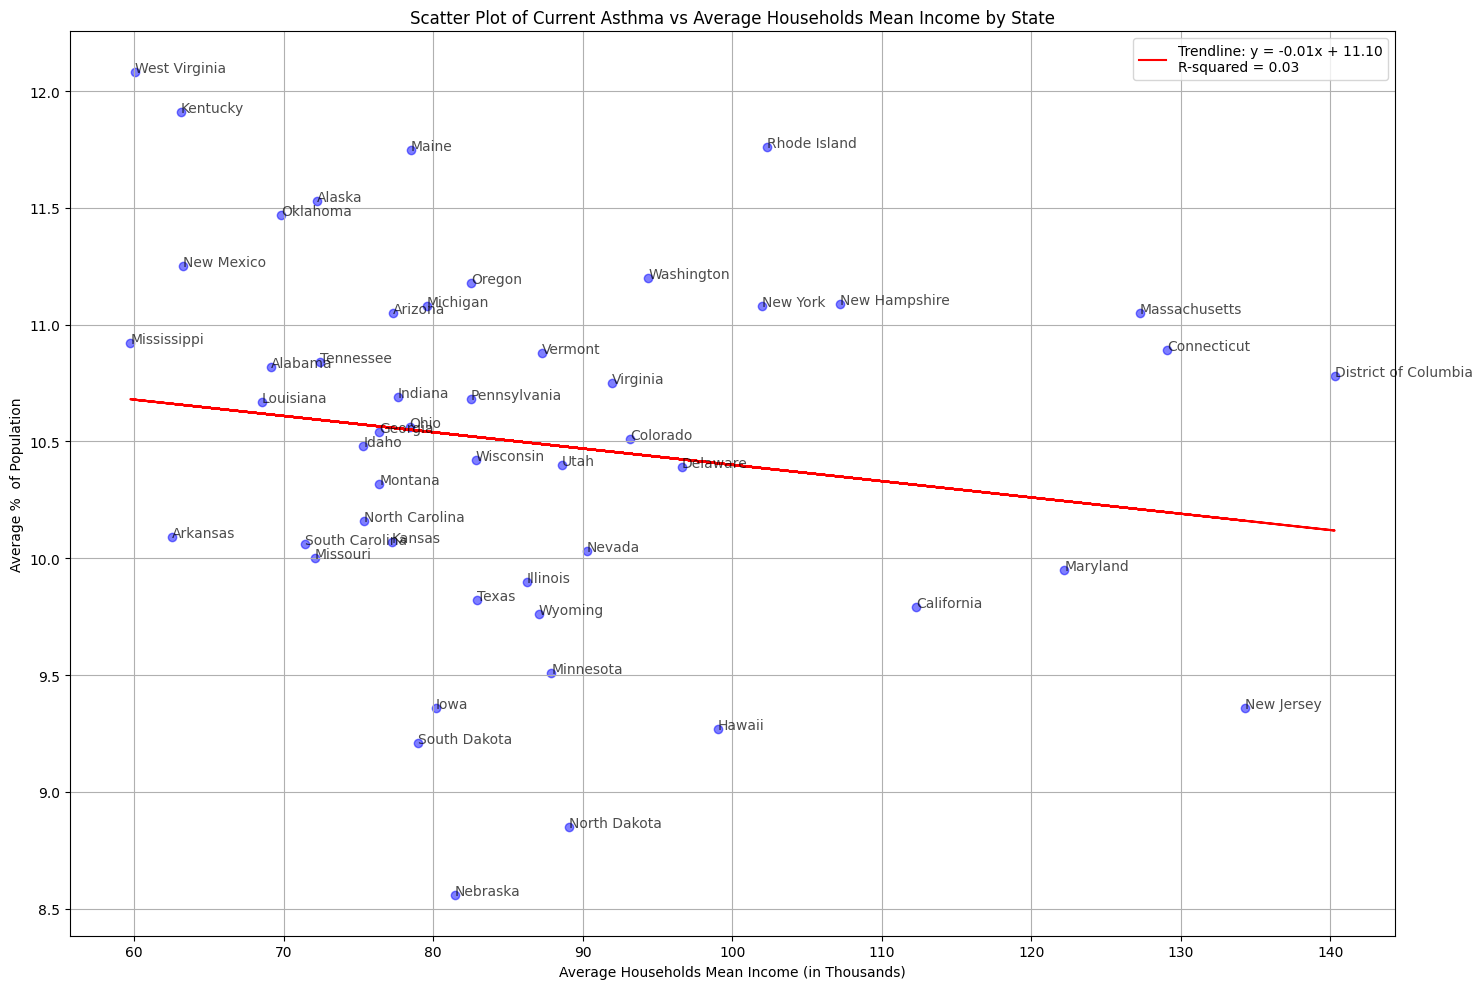

<ipython-input-20-f1930b4ae5b7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_data['Zip Code'] = outcome_data['Zip Code'].astype(int)


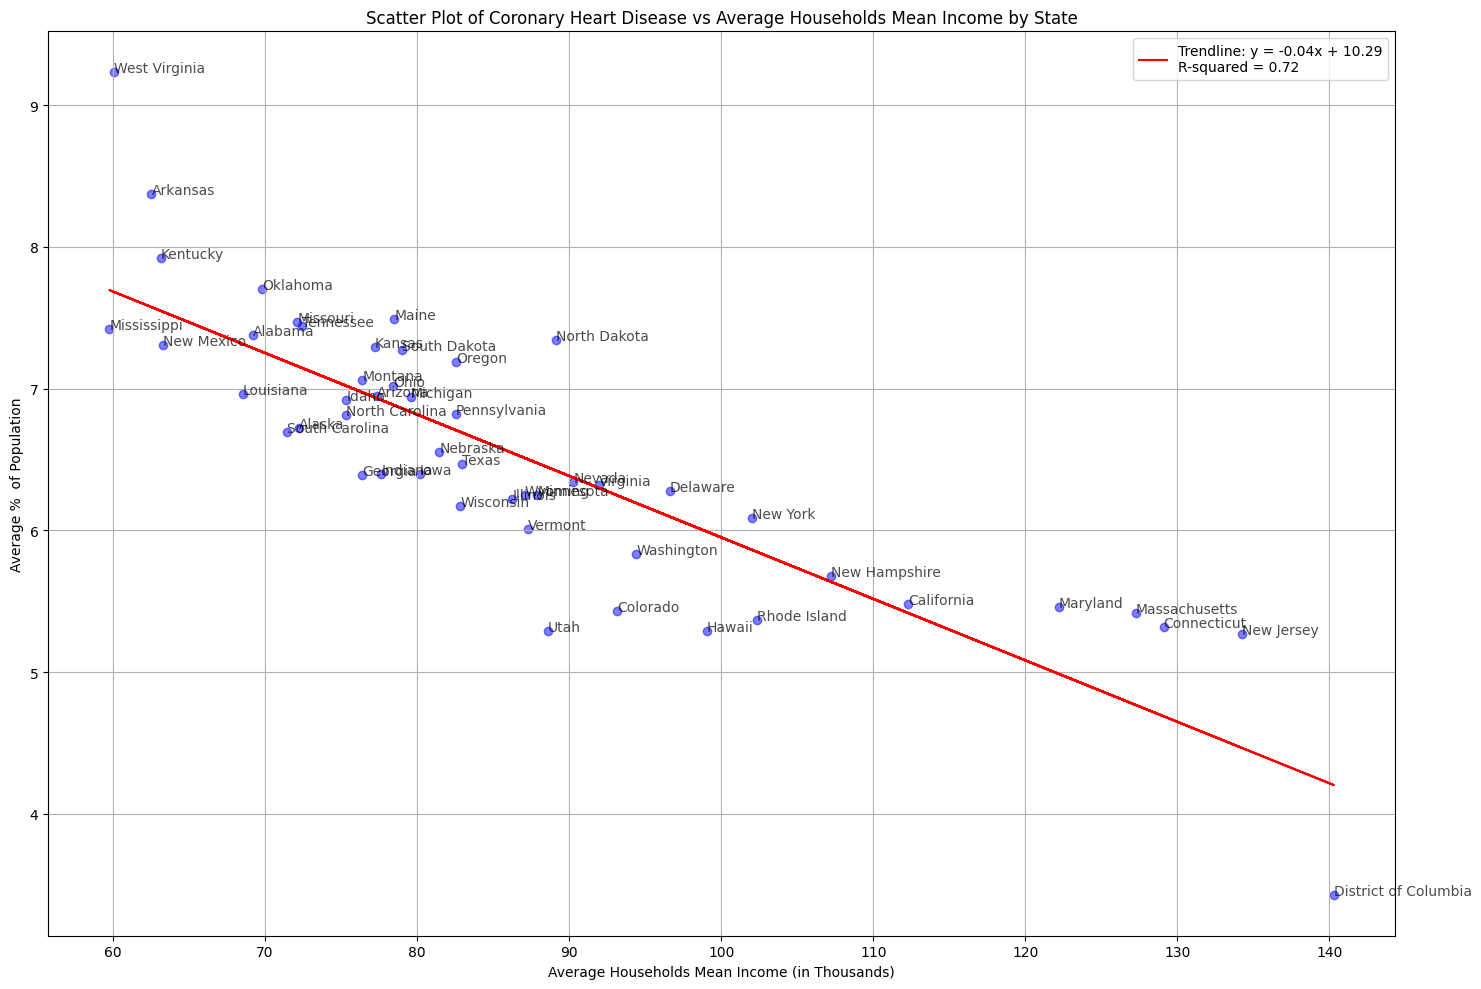

<ipython-input-20-f1930b4ae5b7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_data['Zip Code'] = outcome_data['Zip Code'].astype(int)


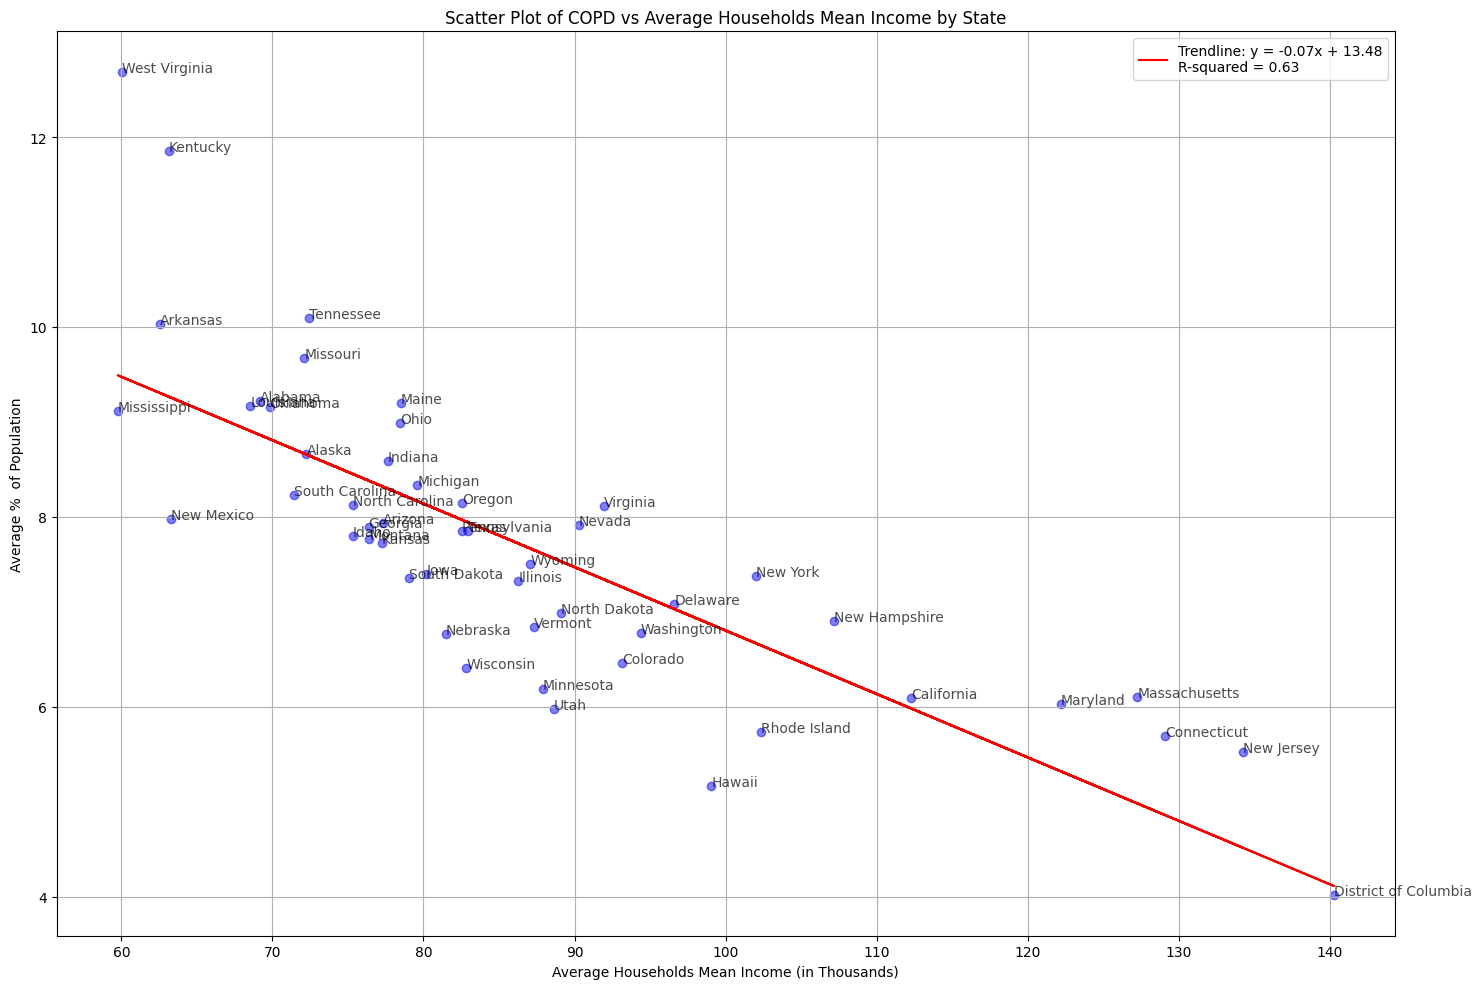

<ipython-input-20-f1930b4ae5b7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_data['Zip Code'] = outcome_data['Zip Code'].astype(int)


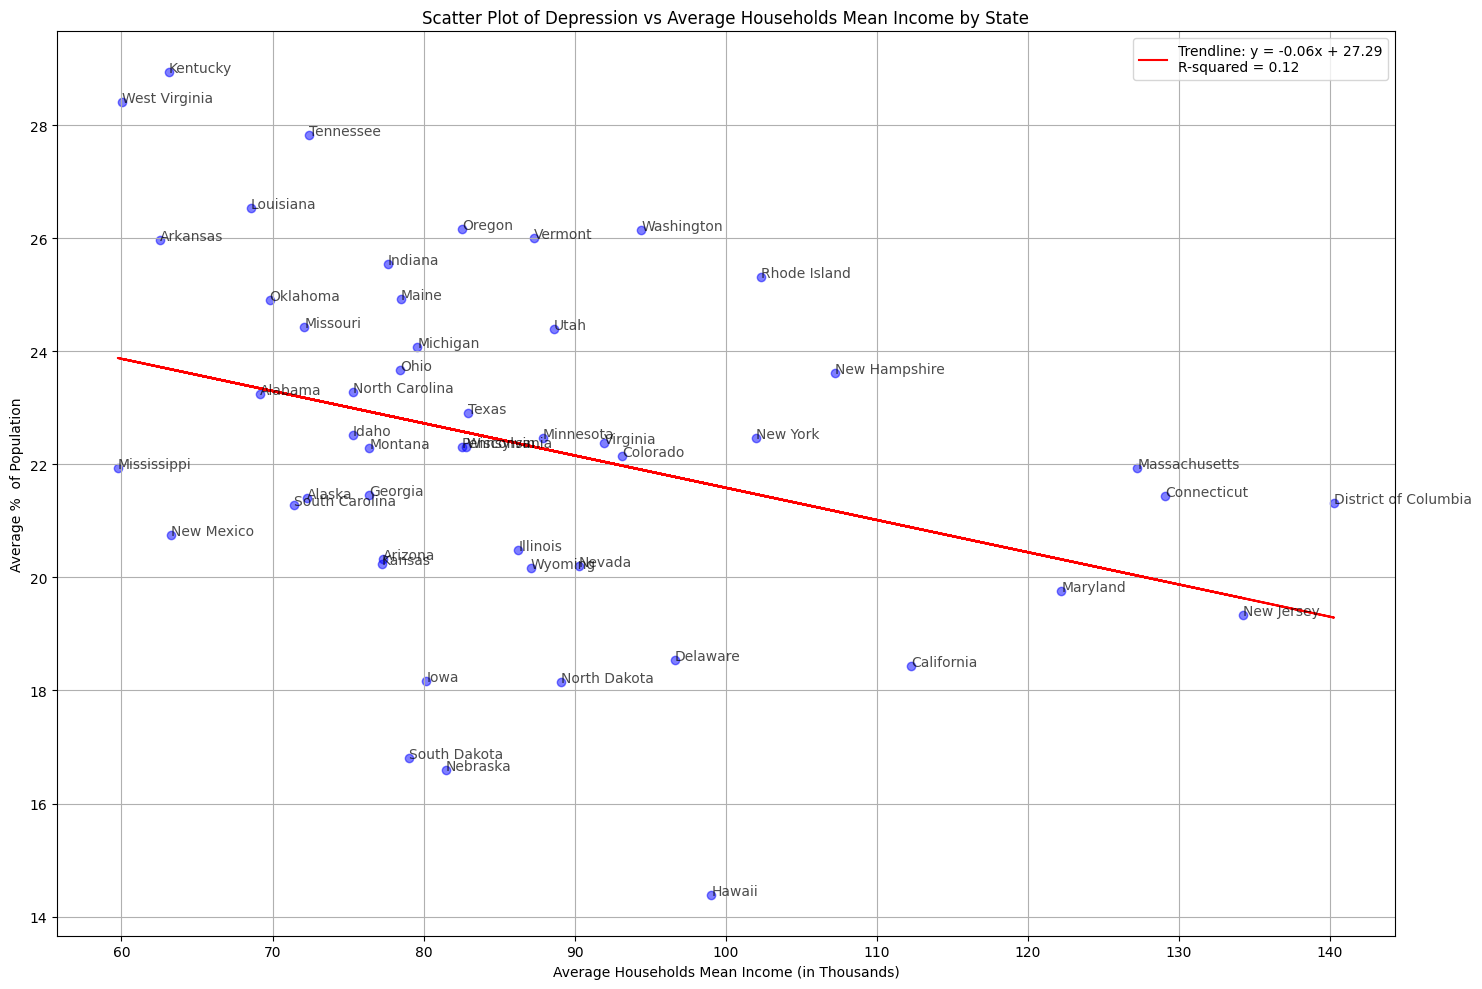

<ipython-input-20-f1930b4ae5b7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_data['Zip Code'] = outcome_data['Zip Code'].astype(int)


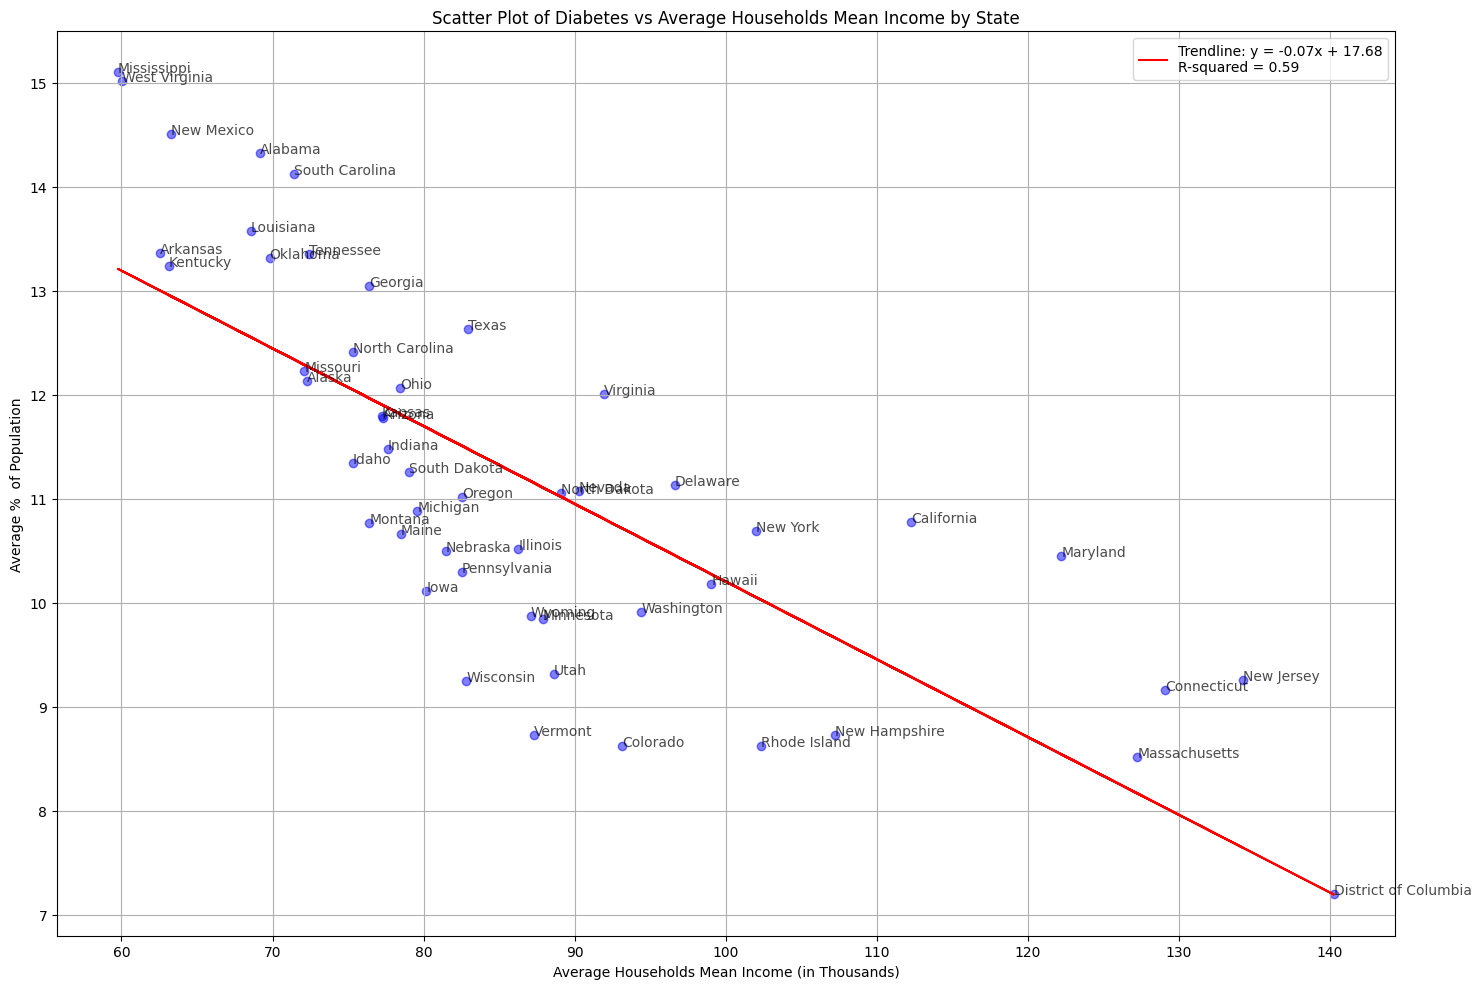

<ipython-input-20-f1930b4ae5b7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_data['Zip Code'] = outcome_data['Zip Code'].astype(int)


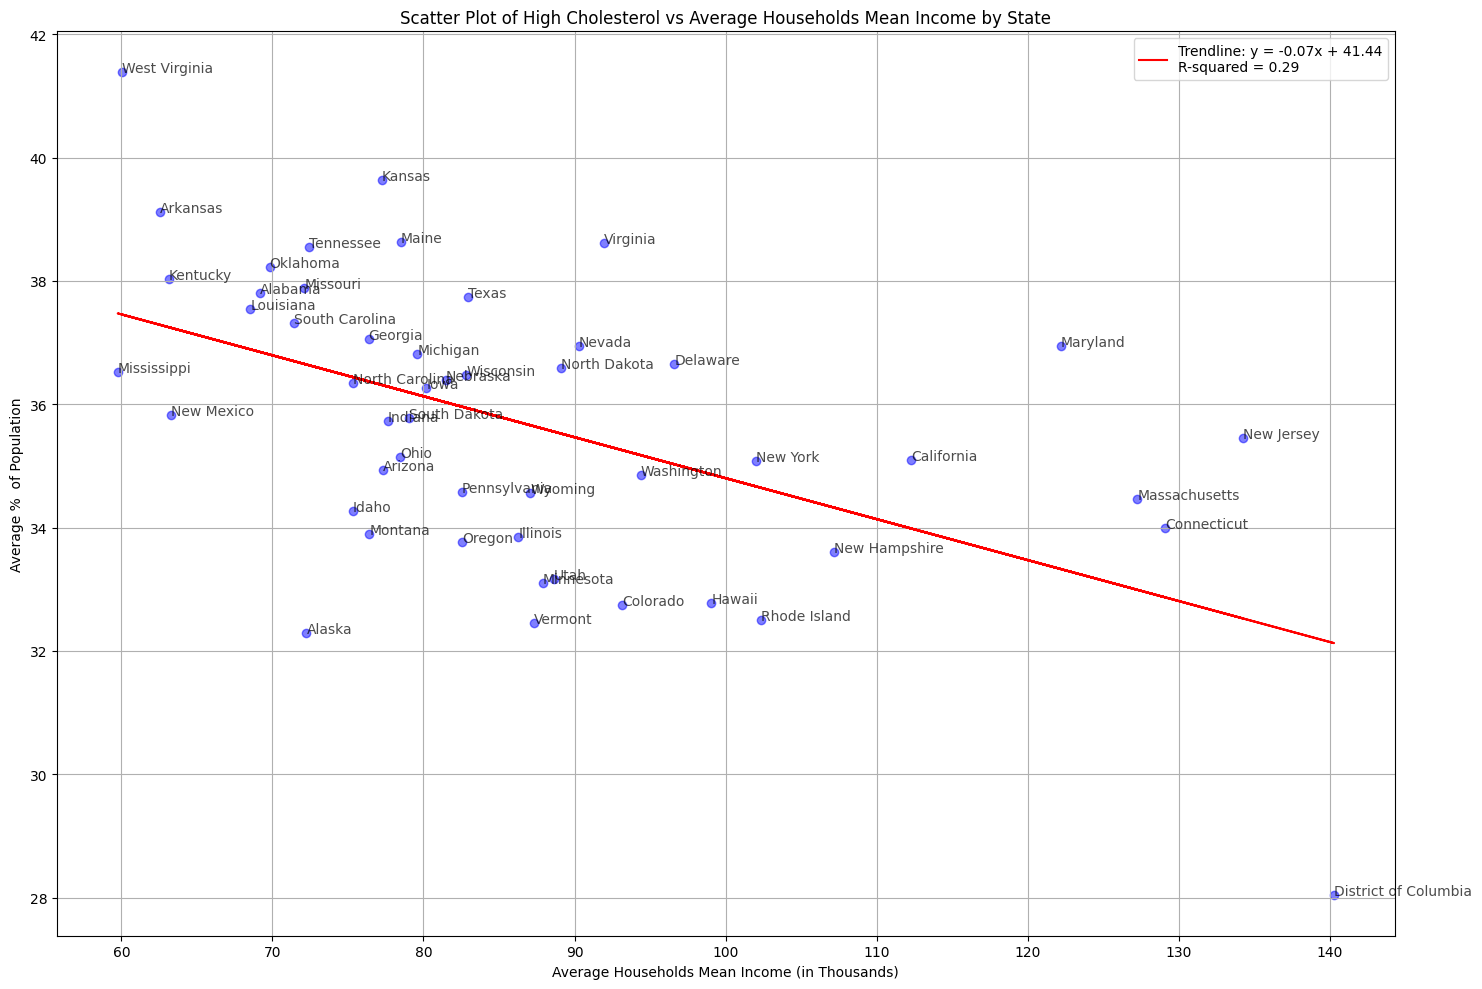

<ipython-input-20-f1930b4ae5b7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_data['Zip Code'] = outcome_data['Zip Code'].astype(int)


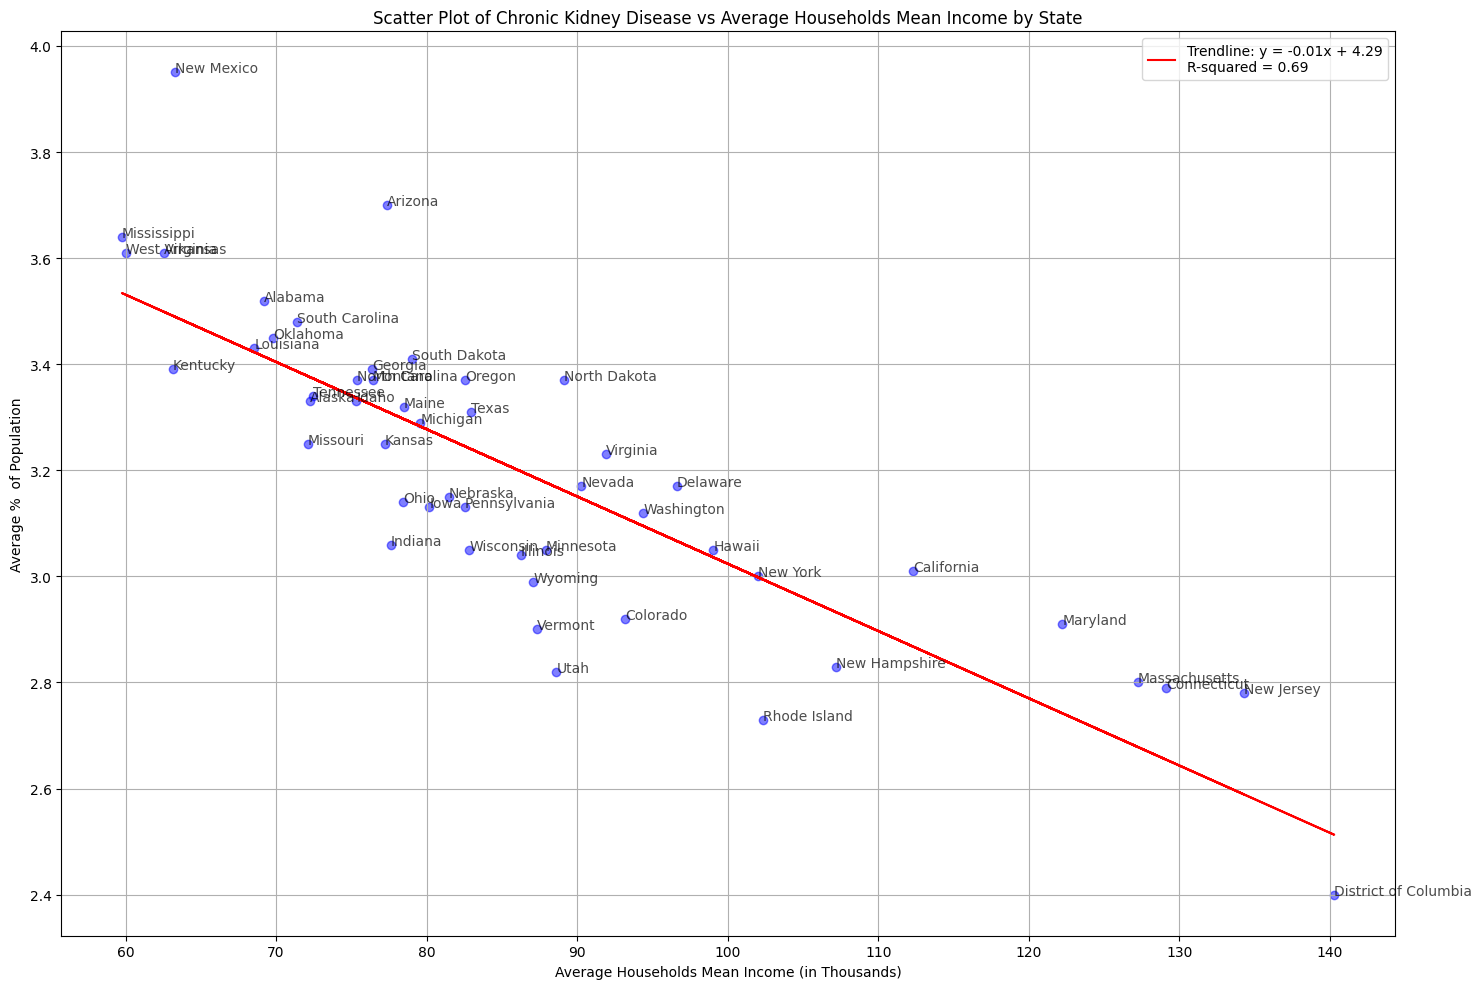

<ipython-input-20-f1930b4ae5b7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_data['Zip Code'] = outcome_data['Zip Code'].astype(int)


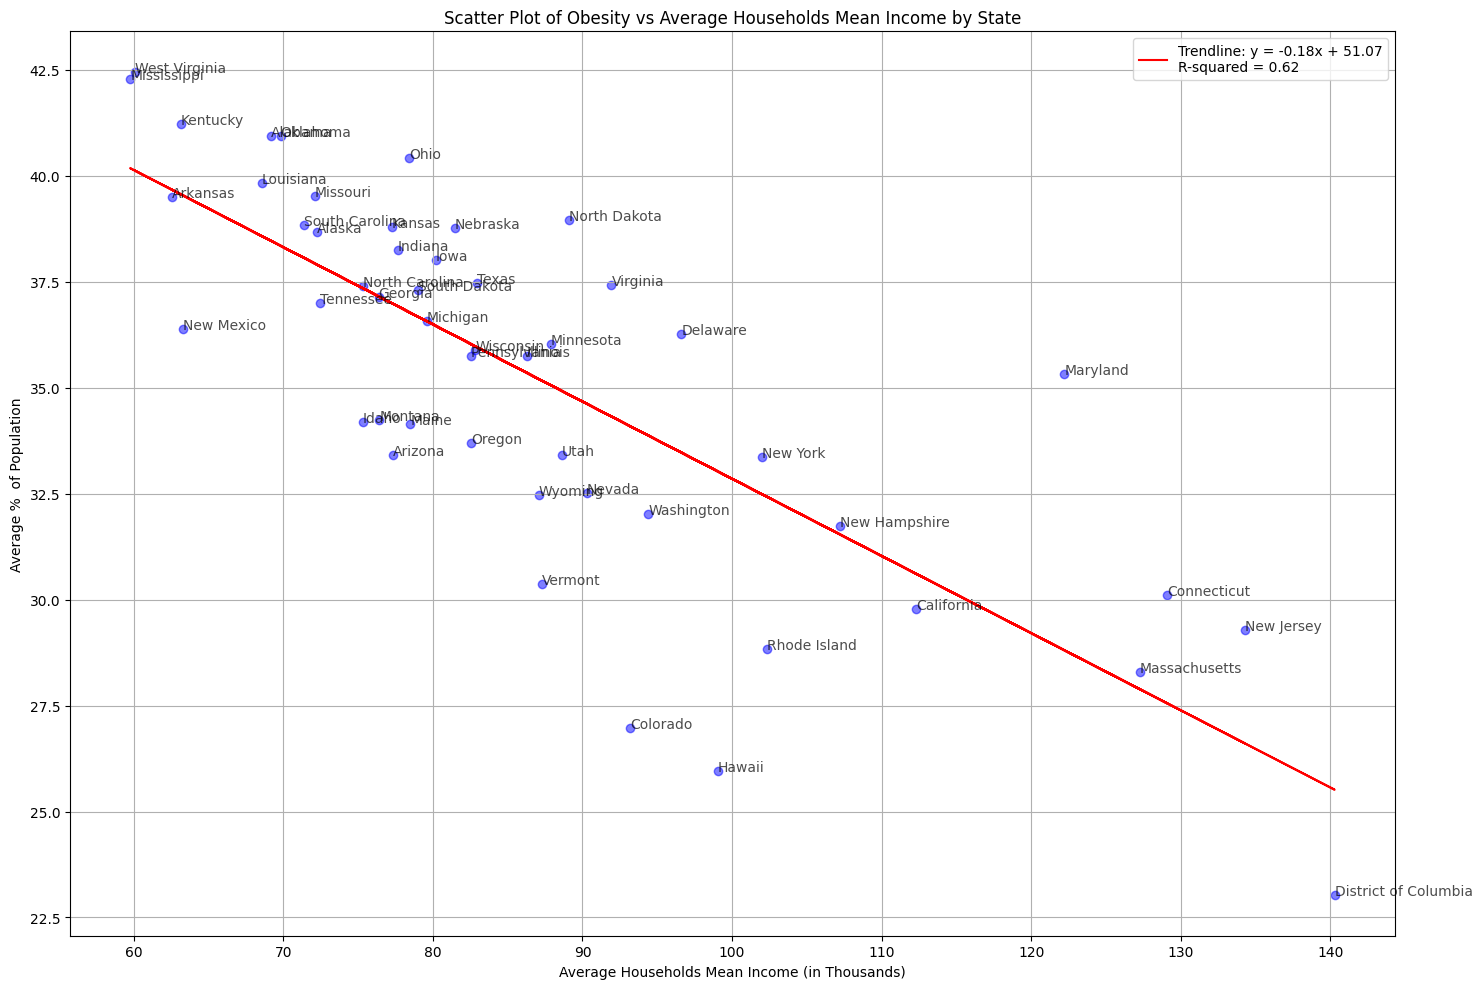

<ipython-input-20-f1930b4ae5b7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_data['Zip Code'] = outcome_data['Zip Code'].astype(int)


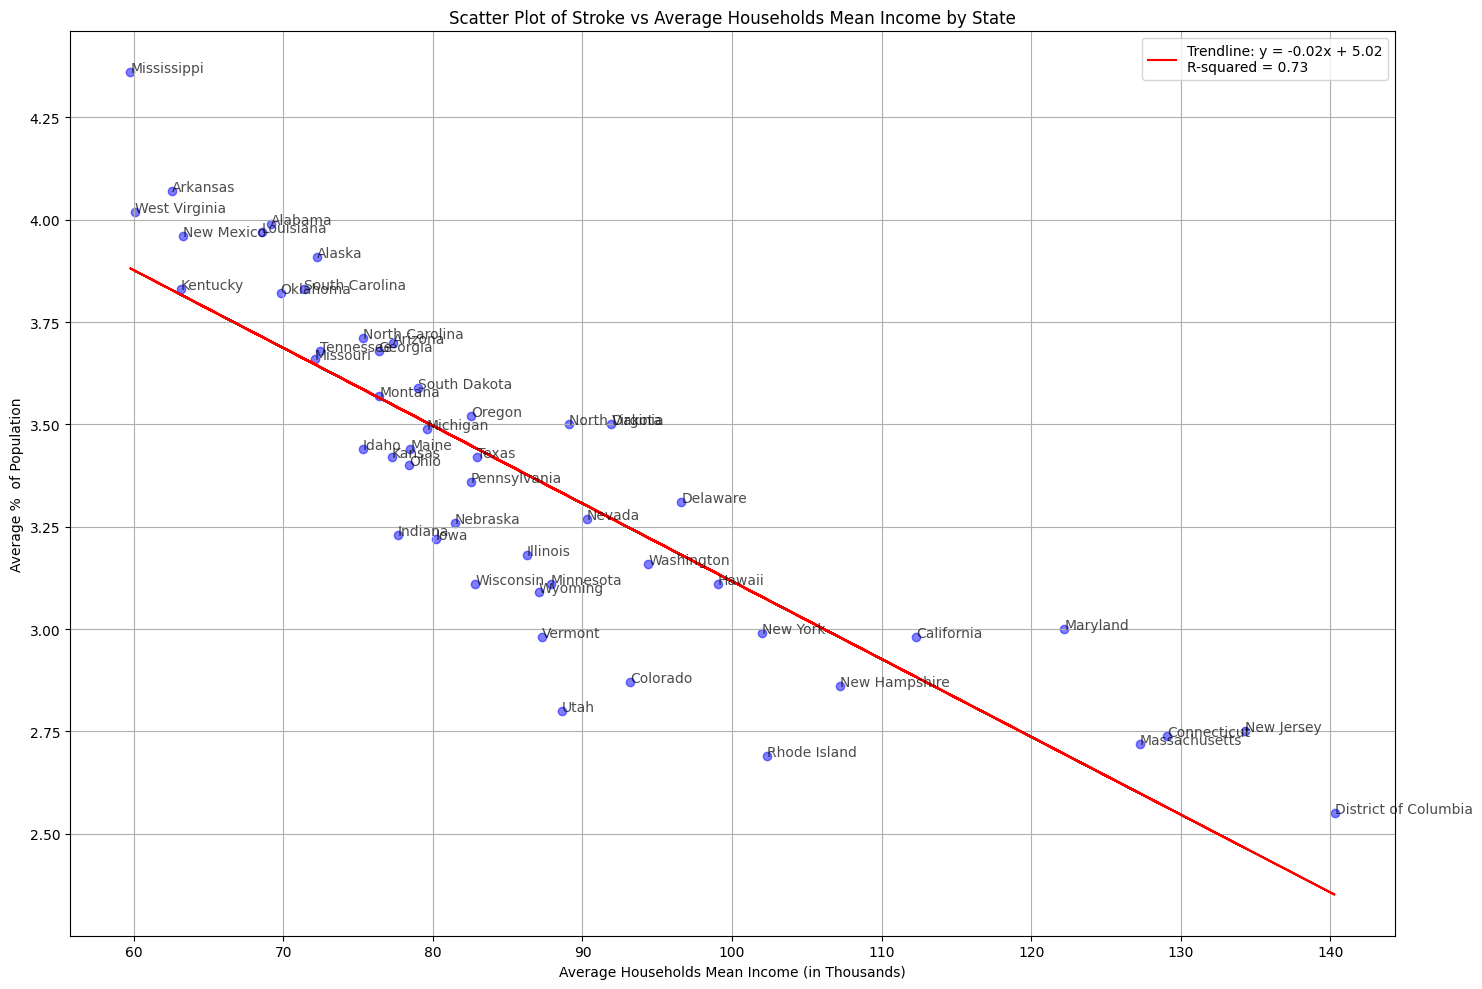

In [ ]:
outcomes = health_outcomes[health_outcomes["Category"] == "Health Outcomes"]

unique_outcomes = outcomes["Short_Question_Text"].unique()
unique_outcomes = np.delete(unique_outcomes, -1)
for o in unique_outcomes:
    scatter_health_outcome(o, income_2021, state_zips)

# Heatmap of Health Outcomes


In [ ]:
def heatmap_health_outcome(income_data, states_zips):
    # Cleann health outcome data
    health_data = health_outcomes[health_outcomes["Category"] == "Health Outcomes"]
    health_data = health_data[health_data["Year"] == 2021]
    health_data = health_data[
        ["LocationName", "Measure", "Data_Value", "Short_Question_Text"]
    ]
    health_data.columns = [["Zip Code", "Measure", "Value", "Text"]]
    health_data.columns = health_data.columns.get_level_values(0)

    merged_data = health_data.merge(income_data, how="inner", on="Zip Code")

    # Merge to get State Names
    merged_data["Zip Code"] = merged_data["Zip Code"].astype(int)
    state_zips["Zip Code"] = state_zips["Zip Code"].astype(int)

    outcome_data_merged = state_zips.merge(merged_data, how="inner", on="Zip Code")

    grouped_df = (
        outcome_data_merged.groupby(["Official State Name", "Text"])["Value"]
        .mean()
        .reset_index()
    )

    heatmap_data = grouped_df.pivot(
        index="Official State Name", columns="Text", values="Value"
    )

    # Create the heatmap
    plt.figure(figsize=(12, 12))
    sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
    plt.title("Health Outcomes in Each State")
    plt.xlabel("Health Outcome")
    plt.ylabel("Official State Name")
    plt.show()

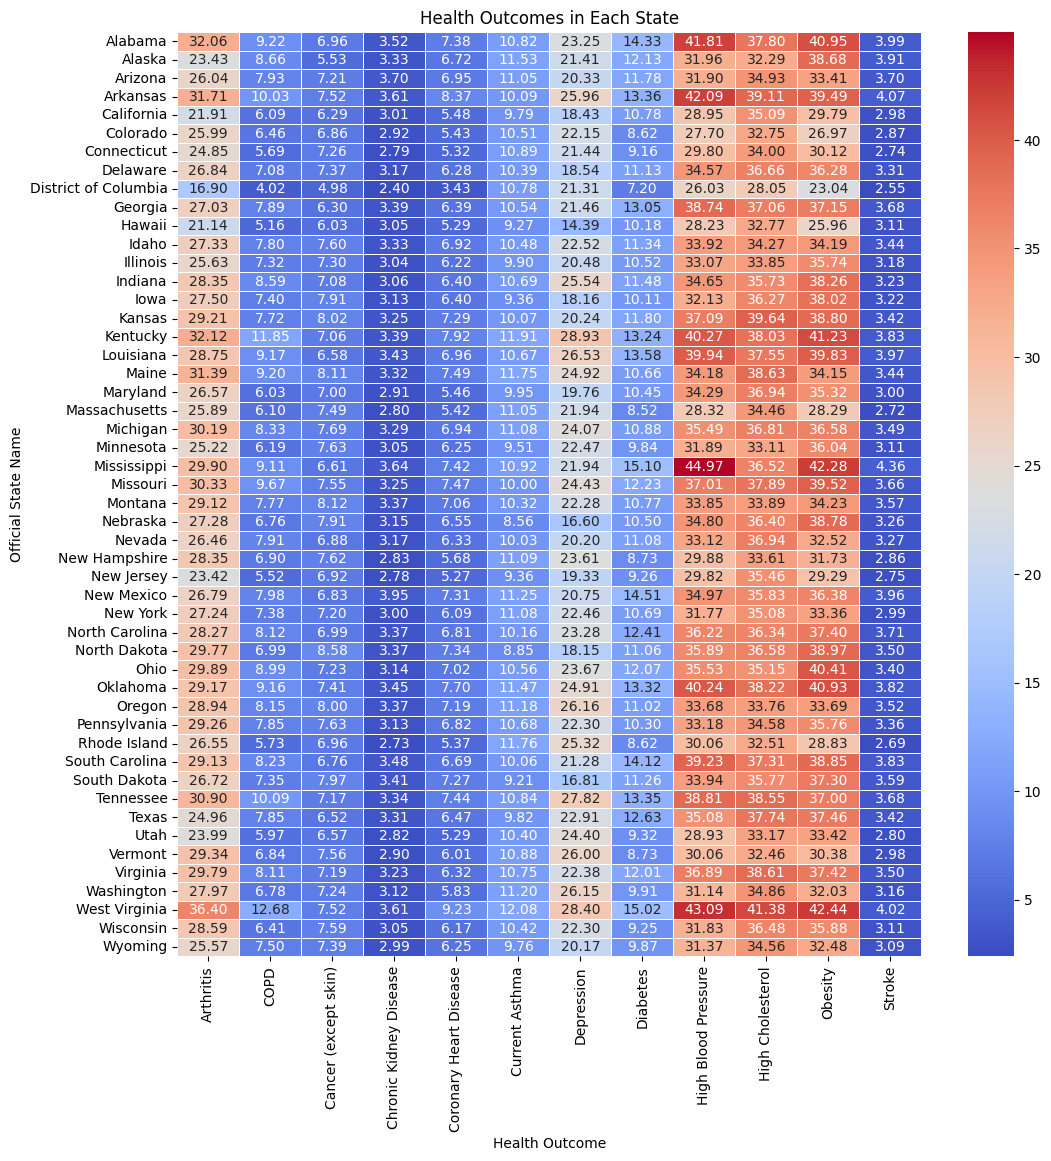

In [ ]:
heatmap_health_outcome(income_2021, state_zips)

# Map of Health Outcome


In [ ]:
def map_health_outcome(outcome, state, income_data, states_zips):
    # Filter the data for 'Health Outcomes' category and the year 2021
    health_data = health_outcomes[
        (health_outcomes["Category"] == "Health Outcomes")
        & (health_outcomes["Year"] == 2021)
    ]

    # Select the desired columns and rename them
    health_data = health_data[
        ["LocationName", "Measure", "Data_Value", "Short_Question_Text", "Geolocation"]
    ]
    health_data.columns = ["Zip Code", "Measure", "Value", "Text", "Geolocation"]

    merged_data = health_data.merge(income_data, how="inner", on="Zip Code")

    outcome_data = merged_data[merged_data["Text"] == outcome]

    # Merge to get State Names
    outcome_data["Zip Code"] = outcome_data["Zip Code"].astype(int)
    state_zips["Zip Code"] = state_zips["Zip Code"].astype(int)

    outcome_data_merged = state_zips.merge(outcome_data, how="inner", on="Zip Code")
    outcome_data_merged["Geolocation"] = outcome_data_merged["Geolocation"].str.replace(
        "POINT", ""
    )
    outcome_data_merged["Geolocation"] = outcome_data_merged["Geolocation"].str.replace(
        "(", ""
    )
    outcome_data_merged["Geolocation"] = outcome_data_merged["Geolocation"].str.replace(
        ")", ""
    )
    outcome_data_merged = outcome_data_merged[
        outcome_data_merged["Official State Name"] == state
    ]

    outcome_data_merged[["s", "lon", "lat"]] = outcome_data_merged[
        "Geolocation"
    ].str.split(" ", expand=True)
    outcome_data_merged = outcome_data_merged.drop(columns=["Geolocation", "s"])

    # Sort the DataFrame by the 'Value' column in descending order and select the top 10 rows
    top_10_zipcodes = outcome_data_merged.sort_values(by="Value", ascending=False).head(
        10
    )

    # Create a Folium map centered around the first row's coordinates
    m = folium.Map(
        location=[top_10_zipcodes["lat"].iloc[0], top_10_zipcodes["lon"].iloc[0]],
        zoom_start=10,
    )

    # Add markers for the top 10 zip codes
    for index, row in top_10_zipcodes.iterrows():
        folium.Marker(
            location=[row["lat"], row["lon"]],
            popup=f"Zip Code: {row['Zip Code']}\nState: {row['Official State Name']}\nValue: {row['Value']}",
            icon=folium.Icon(icon="cloud"),
        ).add_to(m)

    # Display the map
    m.save("map.html")  # Save the map to an HTML file
    return m

In [ ]:
map_health_outcome("Depression", "New York", income_2021, state_zips)

<ipython-input-24-5c26ddce6fd6>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outcome_data['Zip Code'] = outcome_data['Zip Code'].astype(int)
<ipython-input-24-5c26ddce6fd6>:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  outcome_data_merged['Geolocation'] = outcome_data_merged['Geolocation'].str.replace('(', '')
<ipython-input-24-5c26ddce6fd6>:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  outcome_data_merged['Geolocation'] = 